In [11]:
import os
import numpy as np
from PIL import Image, ImageDraw
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from scipy.stats import mode
from sklearn.metrics import precision_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns

In [3]:
class PCA:
    def __init__(self, n_components, max_iter=1000, tol=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.mean = None
        self.components = []

    def _power_iteration(self, A):
        n = A.shape[0]
        v = np.random.rand(n)
        v = v / np.linalg.norm(v)

        for _ in range(self.max_iter):
            Av = np.dot(A, v)
            v_new = Av / np.linalg.norm(Av)
            if np.linalg.norm(v - v_new) < self.tol:
                break
            v = v_new

        eigenvalue = np.dot(v.T, np.dot(A, v))
        return eigenvalue, v

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.dot(X_centered.T, X_centered) / (X_centered.shape[0] - 1)

        components = []
        for _ in range(self.n_components):
            eigenvalue, eigenvector = self._power_iteration(cov_matrix)
            components.append(eigenvector)
            cov_matrix = cov_matrix - eigenvalue * np.outer(eigenvector, eigenvector)

        self.components = np.array(components)

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components.T)

def load_images(folder_planes, folder_noplanes, image_size=(64, 64)):
    X = []
    y = []
    for filename in os.listdir(folder_planes):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder_planes, filename)
            img = Image.open(img_path).convert('L').resize(image_size)
            img_array = np.array(img).flatten()
            X.append(img_array)
            y.append(1)

    for filename in os.listdir(folder_noplanes):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder_noplanes, filename)
            img = Image.open(img_path).convert('L').resize(image_size)
            img_array = np.array(img).flatten()
            X.append(img_array)
            y.append(0)

    return np.array(X), np.array(y)

In [4]:
train_planes_folder = '/Users/annapaskovska/Desktop/linijka/planes/train'
train_noplanes_folder = '/Users/annapaskovska/Desktop/linijka/without_planes/Data/Train'
val_planes_folder = '/Users/annapaskovska/Desktop/linijka/planes/val'
val_noplanes_folder = '/Users/annapaskovska/Desktop/linijka/without_planes/Data/Valid'

X_train, y_train = load_images(train_planes_folder, train_noplanes_folder)
X_val, y_val = load_images(val_planes_folder, val_noplanes_folder)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Training set: (3290, 4096), (3290,)
Validation set: (520, 4096), (520,)


In [5]:
pca = PCA(n_components=10)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

print(f"After PCA, training set shape: {X_train_pca.shape}")
print(f"After PCA, validation set shape: {X_val_pca.shape}")

After PCA, training set shape: (3290, 10)
After PCA, validation set shape: (520, 10)


In [ ]:

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_pca)
train_preds = kmeans.predict(X_train_pca)

label_map = {}
for cluster in np.unique(train_preds):
    indices = np.where(train_preds == cluster)
    true_labels = y_train[indices]
    most_common = mode(true_labels, keepdims=True).mode[0]

    label_map[cluster] = most_common

In [ ]:
y_pred = np.array([label_map[cluster] for cluster in kmeans.predict(X_val_pca)])

accuracy = accuracy_score(y_val, y_pred)
sensitivity = recall_score(y_val, y_pred)

print(f"Validation Accuracy: {accuracy*100:.2f}%")
print(f"Validation Sensitivity: {sensitivity*100:.2f}%")

Validation Accuracy: 70.96%
Validation Sensitivity: 69.05%


In [13]:
y_pred = kmeans.predict(X_val_pca)

accuracy = accuracy_score(y_val, y_pred)
sensitivity = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

metrics = {
    "Metric": ["Accuracy", "Recall (Sensitivity)", "Precision", "F1 Score"],
    "Value (%)": [accuracy * 100, sensitivity * 100, precision * 100, f1 * 100]
}

metrics_df = pd.DataFrame(metrics)

metrics_df["Value (%)"] = metrics_df["Value (%)"].round(2)

print("Evaluation Metrics Table:")
metrics_df.style

Evaluation Metrics Table:


Predictions on TRAINING set:


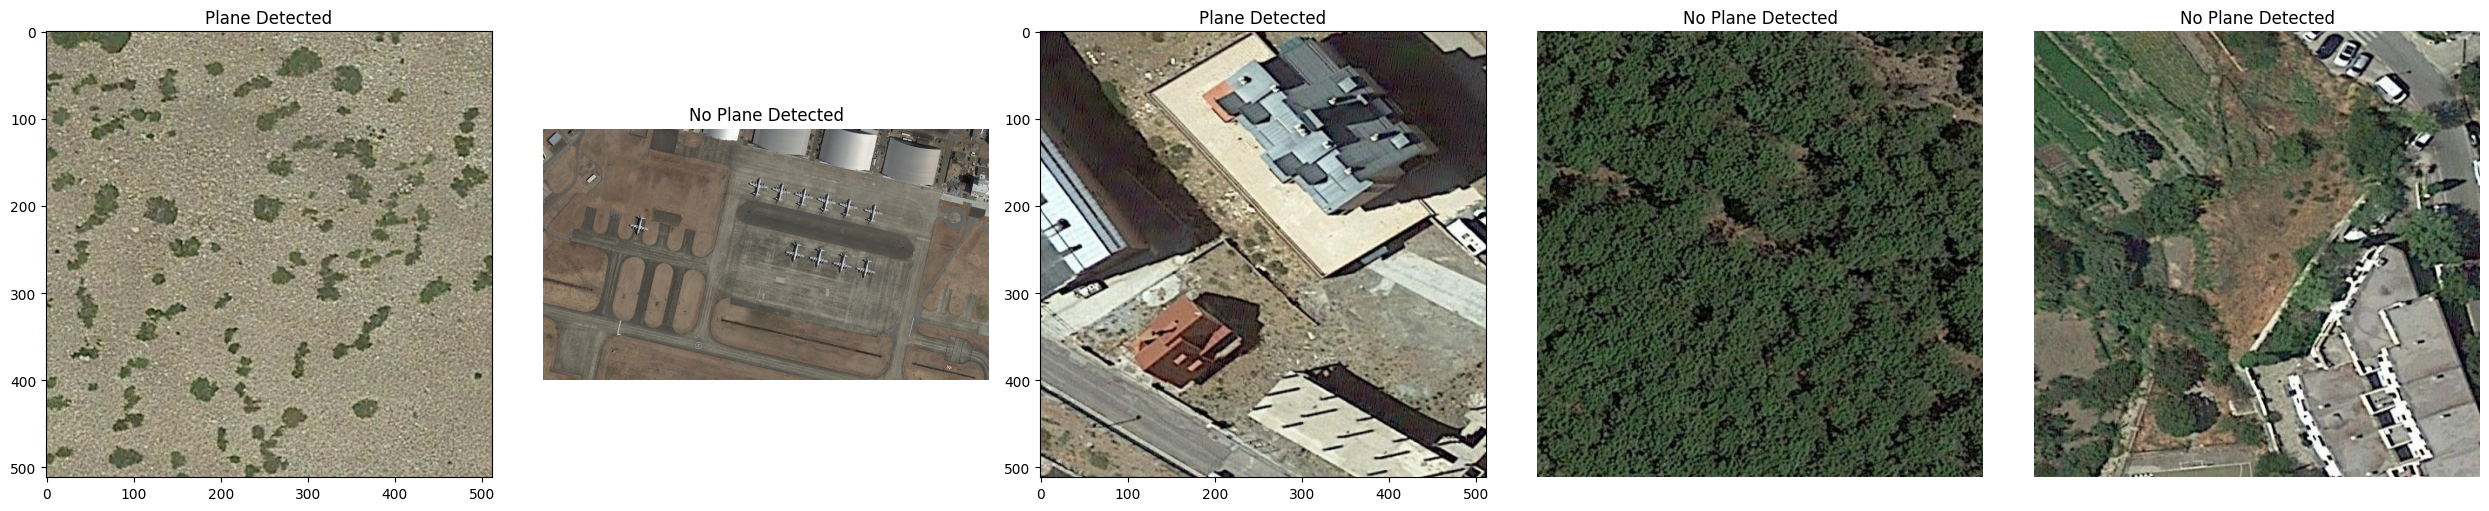

Predictions on VALIDATION set:


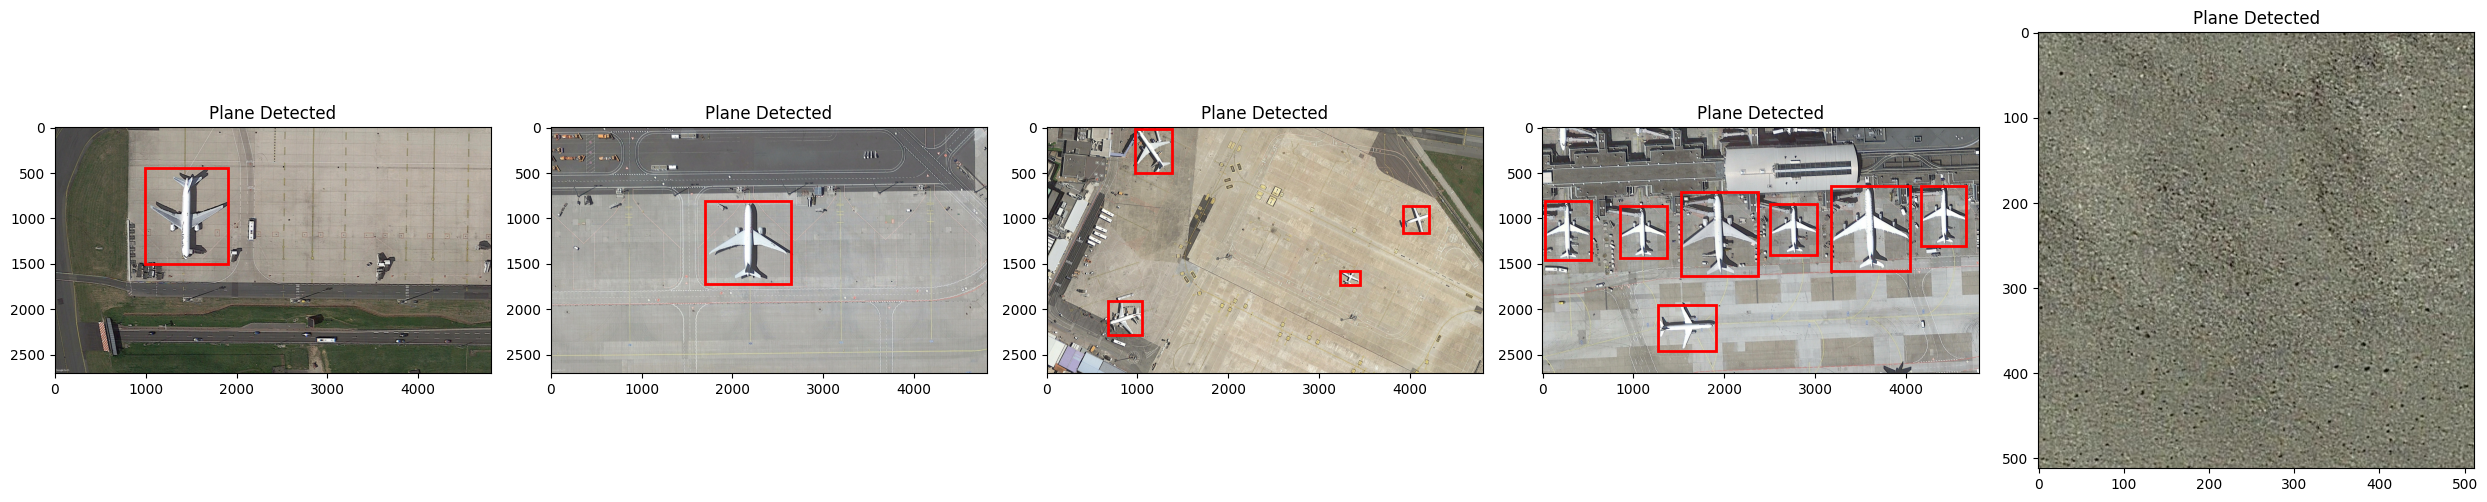

In [8]:


def draw_boxes_from_txt(img_path, ax):
    txt_path = os.path.splitext(img_path)[0] + '.txt'
    img = Image.open(img_path)
    ax.imshow(img)
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x_center, y_center, width, height = map(float, parts)
                    x = (x_center - width / 2) * img.width
                    y = (y_center - height / 2) * img.height
                    w = width * img.width
                    h = height * img.height
                    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)

def predict_and_visualize(folder_planes, folder_noplanes, n_samples=10):
    image_paths = []
    for folder in [folder_planes, folder_noplanes]:
        image_paths.extend([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.jpg', '.png'))])

    sample_images = random.sample(image_paths, min(n_samples, len(image_paths)))
    fig, axs = plt.subplots(1, len(sample_images), figsize=(5 * len(sample_images), 5))
    if len(sample_images) == 1:
        axs = [axs]

    for img_path, ax in zip(sample_images, axs):
        img = Image.open(img_path).convert('L').resize((64, 64))
        img_array = np.array(img).flatten()
        img_pca = pca.transform(img_array.reshape(1, -1))
        cluster = kmeans.predict(img_pca)[0]
        pred = label_map[cluster]

        if pred == 0:
            img = Image.open(img_path)
            ax.imshow(img, cmap='gray')
            ax.set_title(f"No Plane Detected")
            ax.set_axis_off()
        else:
            draw_boxes_from_txt(img_path, ax)
            ax.set_title(f"Plane Detected")

    plt.tight_layout()
    plt.show()

print("Predictions on TRAINING set:")
predict_and_visualize(train_planes_folder, train_noplanes_folder, n_samples=5)

print("Predictions on VALIDATION set:")
predict_and_visualize(val_planes_folder, val_noplanes_folder, n_samples=5)
